SPHERE on real data

1. scaled_he_image + stardist（H&E 核分割）
2. expand_labels（核到细胞边界扩张）
2. grid_image + stardist（GEX细胞范围分割）
4. salvage_secondary_labels（融合H&E和GEX分割结果）
5. bin_to_cell（关键步骤：得到 cell × gene 矩阵）

In [ ]:
#import os
#os.makedirs("bin2cell/output/Mousebrain/stardist", exist_ok=True)

In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import bin2cell as b2c

# ==== 数据路径 ====

path = "/home/wangzhuo/data/Visium_HD_Mouse_Brain/binned_outputs/square_002um/"
source_image_path ="/home/wangzhuo/data/Visium_HD_Mouse_Brain/Visium_HD_Mouse_Brain_tissue_image.tif"
spaceranger_image_path = "/home/wangzhuo/data/Visium_HD_Mouse_Brain/spatial"

# ==== 1. 读取 VisiumHD 数据 ====
adata = b2c.read_visium(
    path,
    source_image_path=source_image_path,
    spaceranger_image_path=spaceranger_image_path
)
adata.var_names_make_unique()

# 基础过滤（可选）
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=1)

# 设置分辨率（mpp: microns per pixel）
mpp = 0.5

# ==== 2. 生成 H&E 缩放图，供 Stardist 分割用 ====
b2c.scaled_he_image(adata, mpp=mpp, save_path="bin2cell/output/Mousebrain/stardist/he.tiff")
b2c.destripe(adata)
# ==== 3. 细胞核分割（H&E） ====
'''b2c.stardist(image_path="bin2cell/output/Mousebrain/stardist/he.tiff", 
             labels_npz_path="bin2cell/output/Mousebrain/stardist/he.npz", 
             stardist_model="2D_versatile_he", 
             prob_thresh=0.01
            )'''
b2c.insert_labels(adata, 
                  labels_npz_path="bin2cell/output/Mousebrain/stardist/he.npz", 
                  basis="spatial", 
                  spatial_key="spatial_cropped_150_buffer",
                  mpp=mpp, 
                  labels_key="labels_he"
                 )

# ==== 4. 扩张核标签到细胞边界（pseudo cell mask） ====
b2c.expand_labels(
    adata,
    labels_key='labels_he',
    expanded_labels_key="labels_he_expanded"
)

# ==== 5. 基因信号图（用 n_counts_adjusted 生成） ====
b2c.grid_image(adata, "n_counts_adjusted", mpp=mpp, sigma=5, save_path="bin2cell/output/Mousebrain/stardist/gex.tiff")

# ==== 6. 细胞质分割（基因信号） ====
'''b2c.stardist(image_path="bin2cell/output/Mousebrain/stardist/gex.tiff", 
             labels_npz_path="bin2cell/output/Mousebrain/stardist/gex.npz", 
             stardist_model="2D_versatile_fluo", 
             prob_thresh=0.05, 
             nms_thresh=0.5
            )'''
b2c.insert_labels(adata, 
                  labels_npz_path="bin2cell/output/Mousebrain/stardist/gex.npz", 
                  basis="array", 
                  mpp=mpp, 
                  labels_key="labels_gex"
                 )

# ==== 7. 合并核分割 + 质分割结果 ====
b2c.salvage_secondary_labels(
    adata,
    primary_label="labels_he_expanded",
    secondary_label="labels_gex",
    labels_key="labels_joint"
)

# ==== 8. Bin → Cell 分配表达矩阵 ====
'''cdata = b2c.bin_to_cell(
    adata,
    labels_key="labels_joint",
    spatial_keys=["spatial", "spatial_cropped_150_buffer"]
)'''

# 此时 cdata 就是 cell × gene 的表达矩阵
# cdata.obs 包含每个 cell 的 ID / 位置信息
# cdata.var 是基因信息

#print(cdata)

anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Cropped spatial coordinates key: spatial_cropped_150_buffer
Image key: 0.5_mpp_150_buffer


_construct.py (148): Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Salvaged 8060 secondary labels


'cdata = b2c.bin_to_cell(\n    adata,\n    labels_key="labels_joint",\n    spatial_keys=["spatial", "spatial_cropped_150_buffer"]\n)'

Figure Y. Representative visual comparison of Naive (a), Weighted Area (b), and SPHERE (c) methods on EPCAM-stained tissue. The red contour outlines the analyzed tissue region. (d) Difference map showing cell-level score differences between SPHERE and Weighted Area (SPHERE − WA), with positive values (red) indicating higher scores assigned by SPHERE.



In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, MultiPoint
from shapely.validation import make_valid
import matplotlib.pyplot as plt


# ==== 1. 自动找ROI ====
def find_high_expr_roi(adata, gene_name, win_row=100, win_col=100):
    expr = np.ravel(adata[:, gene_name].X.toarray())
    rows = adata.obs['array_row'].values
    cols = adata.obs['array_col'].values
    row_min, row_max = rows.min(), rows.max()
    col_min, col_max = cols.min(), cols.max()

    best_score = -np.inf
    best_roi = None
    for r0 in range(row_min, row_max - win_row, win_row // 2):
        for c0 in range(col_min, col_max - win_col, win_col // 2):
            r1 = r0 + win_row
            c1 = c0 + win_col
            mask = (rows >= r0) & (rows <= r1) & (cols >= c0) & (cols <= c1)
            if np.sum(mask) < 10:
                continue
            score = expr[mask].mean()
            if score > best_score:
                best_score = score
                best_roi = (r0, r1, c0, c1)
    return best_roi, best_score


# ==== 2. 三种方法 ====
def naive_assignment(bin_gdf, cell_gdf):
    sj = gpd.sjoin(bin_gdf, cell_gdf, how="inner", predicate="within")
    genes = [c for c in bin_gdf.columns if c != "geometry"]
    sj["cell_id"] = sj["index_right"].map(cell_gdf["cell_id"])
    return sj.groupby("cell_id")[genes].sum()


def weighted_by_area(bin_gdf, cell_gdf):
    genes = [c for c in bin_gdf.columns if c != "geometry"]
    sj = gpd.sjoin(bin_gdf, cell_gdf, how="inner", predicate="intersects")
    sj["overlap_area"] = sj.apply(
        lambda r: r["geometry"].intersection(cell_gdf.loc[r["index_right"], "geometry"]).area, axis=1)
    sj["bin_area"] = sj["geometry"].area
    sj["weight"] = sj["overlap_area"] / sj["bin_area"]
    weighted = sj[genes].multiply(sj["weight"], axis=0)
    weighted["cell_id"] = sj["index_right"].map(cell_gdf["cell_id"])
    return weighted.groupby("cell_id")[genes].sum()


def sphere_assignment(bin_gdf, cell_gdf, alpha=0.01):
    genes = [c for c in bin_gdf.columns if c != "geometry"]
    sj = gpd.sjoin(bin_gdf, cell_gdf, how="inner", predicate="intersects")
    sj["overlap_area"] = sj.apply(
        lambda r: r["geometry"].intersection(cell_gdf.loc[r["index_right"], "geometry"]).area, axis=1)
    sj["bin_area"] = sj["geometry"].area
    sj["area_weight"] = sj["overlap_area"] / sj["bin_area"]

    sj["bin_cx"] = sj["geometry"].centroid.x
    sj["bin_cy"] = sj["geometry"].centroid.y
    cell_gdf["cx"] = cell_gdf["geometry"].centroid.x
    cell_gdf["cy"] = cell_gdf["geometry"].centroid.y
    sj["cell_cx"] = sj["index_right"].map(cell_gdf["cx"])
    sj["cell_cy"] = sj["index_right"].map(cell_gdf["cy"])

    sj["dist_weight"] = np.exp(
        -alpha * np.sqrt((sj["bin_cx"] - sj["cell_cx"]) ** 2 + (sj["bin_cy"] - sj["cell_cy"]) ** 2)
    )
    sj["raw_w"] = sj["area_weight"] * sj["dist_weight"]
    sj["weight"] = sj.groupby(sj.index)["raw_w"].transform(lambda x: x / x.sum())

    weighted = sj[genes].multiply(sj["weight"], axis=0)
    weighted["cell_id"] = sj["index_right"].map(cell_gdf["cell_id"])
    return weighted.groupby("cell_id")[genes].sum()


# ==== 3. 绘图+统计（已改好类型判断）====
def plot_gene_roi_comparison_with_stats(cell_gdf, pred_naive, pred_wa, pred_sphere,
                                        gene, boundary_q=0.6, savepath=None):
    methods = {
        "Naïve": pred_naive,
        "Weighted Area": pred_wa,
        "SPHERE": pred_sphere
    }
    vmin = 0
    vmax = max(pred_naive[gene].max(), pred_wa[gene].max(), pred_sphere[gene].max())

    # ROI 高表达 hull
    mask_ids = pred_sphere.index[pred_sphere[gene] > pred_sphere[gene].quantile(boundary_q)]
    gland_cells = cell_gdf[cell_gdf["cell_id"].isin(mask_ids)]
    gland_hull = MultiPoint([geom.centroid for geom in gland_cells.geometry]).convex_hull

    fig, axes = plt.subplots(1, 4, figsize=(22, 6))

    for ax, (name, expr_df) in zip(axes[:3], methods.items()):
        aligned_expr = expr_df.reindex(cell_gdf["cell_id"]).fillna(0)
        plot_gdf = cell_gdf.assign(expr=aligned_expr[gene].values)
        plot_gdf.plot(column="expr", cmap="viridis", legend=True, ax=ax,
                      edgecolor="black", linewidth=0.2, vmin=vmin, vmax=vmax)

        if isinstance(gland_hull, (Polygon, MultiPolygon)):
            gx, gy = gland_hull.exterior.xy
            ax.plot(gx, gy, color="red", linewidth=1.5)

        ax.set_title(f"{gene} - {name}", fontsize=14)
        ax.axis('off')

    # 差值图
    aligned_sphere = pred_sphere.reindex(cell_gdf["cell_id"]).fillna(0)
    aligned_wa = pred_wa.reindex(cell_gdf["cell_id"]).fillna(0)
    diff_series = aligned_sphere[gene] - aligned_wa[gene]
    plot_gdf_diff = cell_gdf.assign(diff=diff_series.values)
    plot_gdf_diff.plot(column="diff", cmap="bwr", legend=True, ax=axes[3],
                       vmin=-abs(diff_series).max(), vmax=abs(diff_series).max(),
                       edgecolor="black", linewidth=0.2)

    if isinstance(gland_hull, (Polygon, MultiPolygon)):
        gx, gy = gland_hull.exterior.xy
        axes[3].plot(gx, gy, color="red", linewidth=1.5)

    axes[3].set_title(f"{gene}: SPHERE - WA", fontsize=14)
    axes[3].axis('off')

    plt.tight_layout()
    if savepath:
        plt.savefig(f"{savepath}.png", dpi=300)
    plt.close()

    # 统计
    if isinstance(gland_hull, (Polygon, MultiPolygon)):
        gland_ids_in_hull = cell_gdf[cell_gdf.geometry.centroid.within(gland_hull)]["cell_id"]
    else:
        gland_ids_in_hull = []

    stats = {}
    for name, expr_df in methods.items():
        aligned_expr = expr_df.reindex(cell_gdf["cell_id"]).fillna(0)
        if len(gland_ids_in_hull) > 0:
            stats[name] = aligned_expr.loc[gland_ids_in_hull, gene].mean()
        else:
            stats[name] = np.nan

    if not np.isnan(stats["Weighted Area"]) and not np.isnan(stats["SPHERE"]) and stats["Weighted Area"] != 0:
        improvement = (stats["SPHERE"] - stats["Weighted Area"]) / stats["Weighted Area"] * 100
    else:
        improvement = np.nan

    return len(gland_ids_in_hull), stats, improvement


# ==== 4. 全自动批处理 ====
def run_marker_roi_analysis(adata, marker_list, win_row=100, win_col=100, outdir="roi_analysis"):
    os.makedirs(outdir, exist_ok=True)
    all_stats = []
    for gene in marker_list:
        if gene not in adata.var_names:
            print(f"[跳过] {gene} 不在 adata.var_names 中")
            continue
        coords, score = find_high_expr_roi(adata, gene, win_row, win_col)
        r0, r1, c0, c1 = coords
        mask = ((adata.obs['array_row'] >= r0) & (adata.obs['array_row'] <= r1) &
                (adata.obs['array_col'] >= c0) & (adata.obs['array_col'] <= c1))
        adata_roi = adata[mask].copy()

        # bin_gdf
        bin_polygons = []
        half = (2 / 0.5) / 2
        for x, y in adata_roi.obsm['spatial']:
            poly = Polygon([
                (x-half, y-half), (x+half, y-half),
                (x+half, y+half), (x-half, y+half)
            ])
            bin_polygons.append(poly)
        bin_expr = pd.DataFrame(adata_roi.X.toarray(), columns=adata_roi.var_names)
        bin_gdf = gpd.GeoDataFrame(bin_expr, geometry=bin_polygons)

        # cell_gdf
        cell_ids = adata_roi.obs['labels_joint'].values
        coords_roi = adata_roi.obsm['spatial']
        unique_cells = np.unique(cell_ids[cell_ids > 0])
        cell_polys, valid_ids = [], []
        for cid in unique_cells:
            pts = coords_roi[cell_ids == cid]
            if len(pts) >= 3:
                cell_polys.append(make_valid(Polygon(pts).convex_hull))
                valid_ids.append(cid)
        cell_gdf = gpd.GeoDataFrame({"cell_id": valid_ids}, geometry=cell_polys)

        # 三方法
        pred_naive = naive_assignment(bin_gdf, cell_gdf)
        pred_wa = weighted_by_area(bin_gdf, cell_gdf)
        pred_sphere = sphere_assignment(bin_gdf, cell_gdf)

        # 绘图和统计
        outpath = os.path.join(outdir, f"{gene}_roi")
        num_cells, stats, improvement = plot_gene_roi_comparison_with_stats(
            cell_gdf, pred_naive, pred_wa, pred_sphere,
            gene, boundary_q=0.6, savepath=outpath
        )

        all_stats.append({
            "gene": gene,
            "roi_row_range": f"{r0}-{r1}",
            "roi_col_range": f"{c0}-{c1}",
            "roi_mean_expr": score,
            "boundary_cells": num_cells,
            **{f"{k}_mean": v for k, v in stats.items()},
            "SPHERE_vs_WA_%": improvement
        })

    pd.DataFrame(all_stats).to_csv(os.path.join(outdir, "roi_stats_mousebrain.csv"), index=False)
    print(f"分析完成，结果保存在 {outdir}/")





In [3]:
# ==== 5. 小鼠大脑 marker list ====
marker_list_mousebrain = [
    "Slc17a7", "Gad1", "Pvalb", "Sst", "Vip",
     "Mbp",
    "Prox1", "Calb1", "Wfs1", "Grik4",
    "Penk", "Drd1", "Drd2",  "S100b"
]


In [4]:
# ==== 运行 ====
run_marker_roi_analysis(adata, marker_list_mousebrain, win_row=100, win_col=100,
                        outdir="mousebrain_roi_analysis")

分析完成，结果保存在 mousebrain_roi_analysis/


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
def make_mousebrain_figure3_with_scatter_narrow(outdir_roi, top_n_visual=4, fig3_prefix="Figure3_mousebrain"):
    """
    Figure3：
      上部：ROI 面板 (a)
      下部：左 b 图（条形图，窄宽度）+ 右 c 图（散点图，窄宽度）
    同时输出 PNG 和 PDF
    """
    import matplotlib.gridspec as gridspec

    # 读取数据
    stats_path = os.path.join(outdir_roi, "roi_stats_mousebrain.csv")
    stats_df = pd.read_csv(stats_path)
    stats_sorted = stats_df.sort_values("SPHERE_vs_WA_%", ascending=False)
    chosen_genes = stats_sorted.head(top_n_visual)["gene"].tolist()

    # 图布局：上面的 ROI 行跨整行，下面一行用 6 列宽度，其中 b,c 各占 2 列，中间留 2 列空白
    fig = plt.figure(figsize=(18, 4*top_n_visual + 6))
    gs = gridspec.GridSpec(top_n_visual + 1, 6, height_ratios=[4]*top_n_visual + [4])

    # ROI 面板 (a)
    for row_idx, gene in enumerate(chosen_genes):
        ax = fig.add_subplot(gs[row_idx, :])  # 跨所有列
        roi_img_path = os.path.join(outdir_roi, f"{gene}_roi.png")
        if os.path.exists(roi_img_path):
            img = plt.imread(roi_img_path)
            ax.imshow(img)
            ax.set_title(gene, fontsize=14, fontweight='bold')
        else:
            ax.text(0.5, 0.5, f"Missing ROI: {gene}", ha='center', va='center')
        ax.axis("off")
        if row_idx == 0:
            ax.text(-0.02, 1.02, "(a)", transform=ax.transAxes,
                    fontsize=14, fontweight='bold')

    # b 图：条形图（窄）
    ax_bar = fig.add_subplot(gs[-1, 0:2])  # 前两列
    sns.barplot(
        data=stats_sorted,
        x="SPHERE_vs_WA_%",
        y="gene",
        palette="viridis",
        ax=ax_bar
    )
    ax_bar.axvline(0, color="black", linewidth=1)
    ax_bar.set_xlabel("ROI Mean Expression Improvement (%)", fontsize=13)
    ax_bar.set_ylabel("")
    ax_bar.set_title("All Markers", fontsize=14)
    ax_bar.text(-0.2, 1.02, "(b)", transform=ax_bar.transAxes,
                fontsize=14, fontweight='bold')

    # c 图：Bland–Altman plot (SPHERE vs WA)
    mean_vals = (stats_df["SPHERE_mean"] + stats_df["Weighted Area_mean"]) / 2
    diff_vals = stats_df["SPHERE_mean"] - stats_df["Weighted Area_mean"]

    ax_ba = fig.add_subplot(gs[-1, 4:6])
    ax_ba.scatter(mean_vals, diff_vals, alpha=0.7, color="steelblue", edgecolors="k", s=50)

    # 添加均差线和一致性界限
    mean_diff = diff_vals.mean()
    sd_diff = diff_vals.std()
    ax_ba.axhline(mean_diff, color='red', linestyle='--', lw=1.2, label=f"Mean diff = {mean_diff:.2f}")
    ax_ba.axhline(mean_diff + 1.96*sd_diff, color='gray', linestyle=':', lw=1)
    ax_ba.axhline(mean_diff - 1.96*sd_diff, color='gray', linestyle=':', lw=1)

    ax_ba.set_xlabel("Mean ROI Expression (SPHERE & WA)", fontsize=13)
    ax_ba.set_ylabel("Difference (SPHERE − WA)", fontsize=13)
    ax_ba.set_title("Bland–Altman Plot", fontsize=14)
    ax_ba.text(-0.25, 1.02, "(c)", transform=ax_ba.transAxes,
            fontsize=14, fontweight='bold')
    ax_ba.legend()

    plt.tight_layout()

    # 输出 PNG 和 PDF
    png_path = f"{fig3_prefix}.png"
    pdf_path = f"{fig3_prefix}.pdf"
    plt.savefig(png_path, dpi=300)
    plt.savefig(pdf_path, dpi=300)
    plt.close()
    print(f"[完成] Figure 3 保存到 {png_path} 和 {pdf_path}")

In [3]:
make_mousebrain_figure3_with_scatter_narrow(
    outdir_roi="mousebrain_roi_analysis",
    top_n_visual=3,
    fig3_prefix="Figure3_mousebrain"
)

3004038240.py (41): 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



[完成] Figure 3 保存到 Figure3_mousebrain.png 和 Figure3_mousebrain.pdf


In [2]:
adata

AnnData object with n_obs × n_vars = 6132629 × 18823
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'destripe_factor', 'n_counts_adjusted', 'labels_he', 'labels_he_expanded', 'labels_gex', 'labels_joint', 'labels_joint_source'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'bin2cell'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

In [9]:
# ==== 5. 小鼠大脑 marker list ====
marker_list_mousebrain = ["Prox1","Calb1","Mbp","Drd1", "Drd2","Grik4","Sst", "Vip","Pvalb","Wfs1","Penk","Slc17a7","S100b","Gad1"]

In [10]:
import numpy as np
import pandas as pd
import scanpy as sc
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.validation import make_valid
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


# ========== 1. 分 patch ==========
def split_patches(adata, patch_size_um, mpp):
    """将真实数据 adata 切成物理尺寸 patch，返回每个 patch 的行列编号和对应索引"""
    coords = adata.obsm["spatial"] * mpp  # 如果 obsm 里是像素坐标，这里乘 mpp 得到 µm
    x_patch = (coords[:, 0] // patch_size_um).astype(int)
    y_patch = (coords[:, 1] // patch_size_um).astype(int)
    patch_ids = [f"{i}_{j}" for i, j in zip(x_patch, y_patch)]
    adata.obs["x_patch"] = x_patch
    adata.obs["y_patch"] = y_patch
    adata.obs["patch_id"] = patch_ids
    return adata.obs["patch_id"].unique().tolist()

def find_largest_patch(adata, label_key="labels_joint"):
    """
    找出 cell 数量最多的 patch_id
    """
    counts = adata.obs.groupby("patch_id")[label_key].apply(lambda x: (x > 0).sum())
    best_patch = counts.sort_values(ascending=False).index[0]
    best_count = counts.max()
    print(f"选中 cell 数最多的 patch: {best_patch}, cell 数量: {best_count}")
    return best_patch


# ========== 2. 提取一个 patch ==========
def extract_patch(adata, patch_id):
    return adata[adata.obs["patch_id"] == patch_id].copy()


# ========== 3. 三方法 ==========
def naive_assignment(bin_gdf, cell_gdf, genes):
    sj = gpd.sjoin(bin_gdf, cell_gdf, how="inner", predicate="within")
    sj["cell_id"] = sj["index_right"].map(cell_gdf["cell_id"])
    return sj.groupby("cell_id")[genes].sum()

def weighted_by_area(bin_gdf, cell_gdf, genes):
    sj = gpd.sjoin(bin_gdf, cell_gdf, how="inner", predicate="intersects")
    sj["overlap_area"] = sj.apply(
        lambda r: r["geometry"].intersection(cell_gdf.loc[r["index_right"], "geometry"]).area, axis=1
    )
    sj["bin_area"] = sj["geometry"].area
    sj["weight"] = sj["overlap_area"] / sj["bin_area"]
    sj["cell_id"] = sj["index_right"].map(cell_gdf["cell_id"])
    weighted = sj[genes].multiply(sj["weight"], axis=0)
    weighted["cell_id"] = sj["cell_id"]
    return weighted.groupby("cell_id")[genes].sum()

def sphere_assignment(bin_gdf, cell_gdf, genes, alpha=0.01):
    sj = gpd.sjoin(bin_gdf, cell_gdf, how="inner", predicate="intersects")
    sj["overlap_area"] = sj.apply(
        lambda r: r["geometry"].intersection(cell_gdf.loc[r["index_right"], "geometry"]).area, axis=1
    )
    sj["bin_area"] = sj["geometry"].area
    sj["area_weight"] = sj["overlap_area"] / sj["bin_area"]

    sj["bin_cx"] = sj["geometry"].apply(lambda g: g.centroid.x)
    sj["bin_cy"] = sj["geometry"].apply(lambda g: g.centroid.y)
    cell_gdf["cx"] = cell_gdf["geometry"].apply(lambda g: g.centroid.x)
    cell_gdf["cy"] = cell_gdf["geometry"].apply(lambda g: g.centroid.y)
    sj["cell_cx"] = sj["index_right"].map(cell_gdf["cx"])
    sj["cell_cy"] = sj["index_right"].map(cell_gdf["cy"])
    sj["dist_weight"] = np.exp(-alpha * np.sqrt((sj["bin_cx"]-sj["cell_cx"])**2 + (sj["bin_cy"]-sj["cell_cy"])**2))

    sj["raw_w"] = sj["area_weight"] * sj["dist_weight"]
    sj["weight"] = sj.groupby(sj.index)["raw_w"].transform(lambda x: x / x.sum())

    sj["cell_id"] = sj["index_right"].map(cell_gdf["cell_id"])
    weighted = sj[genes].multiply(sj["weight"], axis=0)
    weighted["cell_id"] = sj["cell_id"]
    return weighted.groupby("cell_id")[genes].sum()


# ========== 4. 聚类 ==========
def run_clustering(expr_df):
    if expr_df.shape[0] < 3:
        return None
    adata = sc.AnnData(expr_df)
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=min(2000, adata.shape[1]))
    adata = adata[:, adata.var["highly_variable"]]
    if adata.shape[1] < 2:
        return None
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=min(30, adata.shape[1]))
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=1.0)
    return adata


# ========== 5. Figure 5 流程 ==========
def figure5_on_patch(adata_patch, mpp=0.5, markers=["Prox1","Calb1","Mbp"], alpha=0.01):
    # bin_gdf
    half = (2/mpp)/2
    bin_polygons = [Polygon([(x-half, y-half), (x+half, y-half), (x+half, y+half), (x-half, y+half)]) 
                    for x,y in adata_patch.obsm["spatial"]]
    bin_expr = pd.DataFrame(adata_patch.X.toarray(), columns=adata_patch.var_names)
    bin_gdf = gpd.GeoDataFrame(bin_expr, geometry=bin_polygons)

    # cell_gdf
    cell_ids = adata_patch.obs["labels_joint"].values
    coords = adata_patch.obsm["spatial"]
    unique_cells = np.unique(cell_ids[cell_ids > 0])
    cell_polys, valid_ids = [], []
    for cid in unique_cells:
        pts = coords[cell_ids == cid]
        if len(pts) >= 3:
            cell_polys.append(make_valid(Polygon(pts).convex_hull))
            valid_ids.append(cid)
    cell_gdf = gpd.GeoDataFrame({"cell_id": valid_ids}, geometry=cell_polys)

    genes = list(adata_patch.var_names)

    pred_naive = naive_assignment(bin_gdf, cell_gdf, genes)
    pred_wa = weighted_by_area(bin_gdf, cell_gdf, genes)
    pred_sphere = sphere_assignment(bin_gdf, cell_gdf, genes, alpha=alpha)

    # 聚类
    adata_dict = {
        "Naïve": run_clustering(pred_naive),
        "Weighted Area": run_clustering(pred_wa),
        "SPHERE": run_clustering(pred_sphere)
    }

    # 方法间一致性
    methods = list(adata_dict.keys())
    ari_mat, nmi_mat = np.ones((3,3)), np.ones((3,3))
    for i, m1 in enumerate(methods):
        for j, m2 in enumerate(methods):
            if i != j:
                common_ids = adata_dict[m1].obs_names.intersection(adata_dict[m2].obs_names)
                if len(common_ids) > 2:
                    l1 = adata_dict[m1].obs.loc[common_ids,"leiden"]
                    l2 = adata_dict[m2].obs.loc[common_ids,"leiden"]
                    ari_mat[i,j] = adjusted_rand_score(l1, l2)
                    nmi_mat[i,j] = normalized_mutual_info_score(l1, l2)
    fig, axes = plt.subplots(1,2,figsize=(10,4))
    sns.heatmap(ari_mat, annot=True, cmap="YlOrRd", xticklabels=methods, yticklabels=methods, ax=axes[0])
    sns.heatmap(nmi_mat, annot=True, cmap="YlGnBu", xticklabels=methods, yticklabels=methods, ax=axes[1])
    axes[0].set_title("ARI between methods")
    axes[1].set_title("NMI between methods")
    plt.show()

    # marker 空间图
    for gene in markers:
        fig, axes = plt.subplots(1,3,figsize=(15,5))
        for ax, name, pred in zip(axes, methods, [pred_naive, pred_wa, pred_sphere]):
            aligned = pred.reindex(cell_gdf["cell_id"]).fillna(0)
            plot_gdf = cell_gdf.assign(expr=aligned[gene].values)
            plot_gdf.plot(column="expr", cmap="viridis", ax=ax, legend=True)
            ax.set_title(f"{gene} - {name}")
            ax.axis('off')
        plt.show()

    print("Figure 5 done on patch.")


# ======== 用法 ========
# adata = ...  # 你的真实数据 AnnData
# patch_ids = split_patches(adata, patch_size_um=1000, mpp=0.5)
# adata_patch = extract_patch(adata, patch_ids[0])
# figure5_on_patch(adata_patch, mpp=0.5)

In [13]:
# 1. 切 patch
patch_ids = split_patches(adata, patch_size_um=1000, mpp=0.5)

# 2. 自动找 cell 数最多的 patch
best_patch_id = find_largest_patch(adata, label_key="labels_joint")

选中 cell 数最多的 patch: 8_1, cell 数量: 67331


In [5]:
best_patch_id

'8_1'

aligned_df.py (67): Transforming to str index.
_scale.py (316): Received a view of an AnnData. Making a copy.
2025-09-09 09:29:15.810869: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-09 09:29:15.816934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757381355.823402   49070 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757381355.825513   49070 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757381355.830656   4

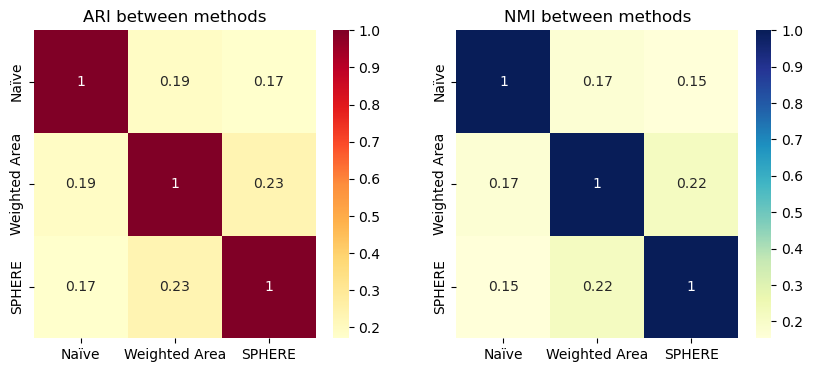

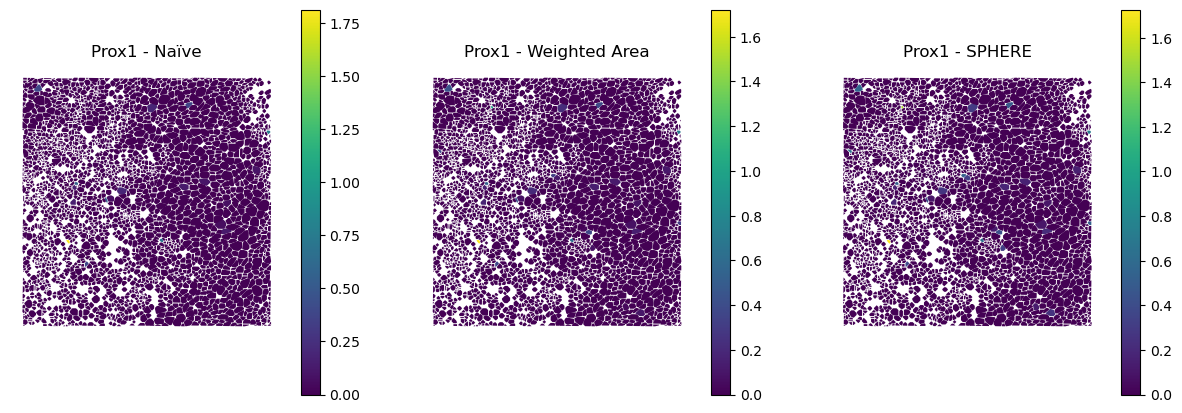

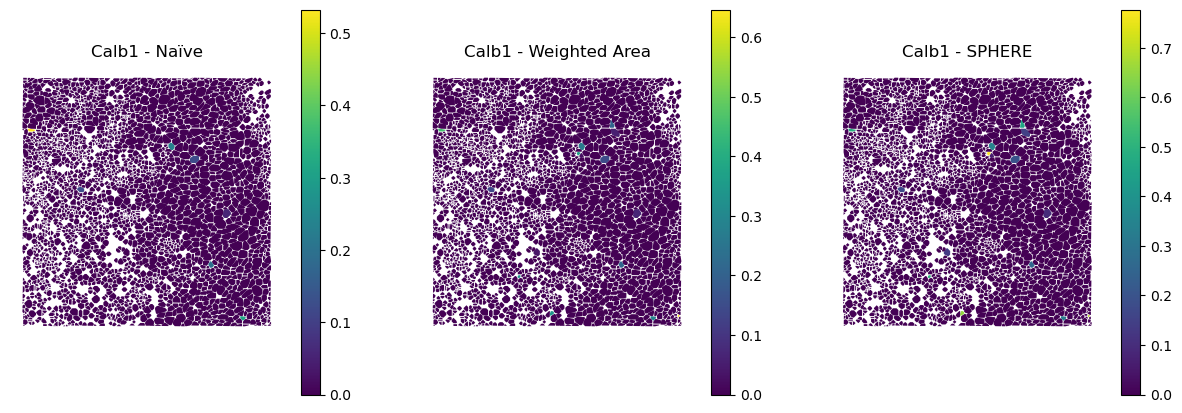

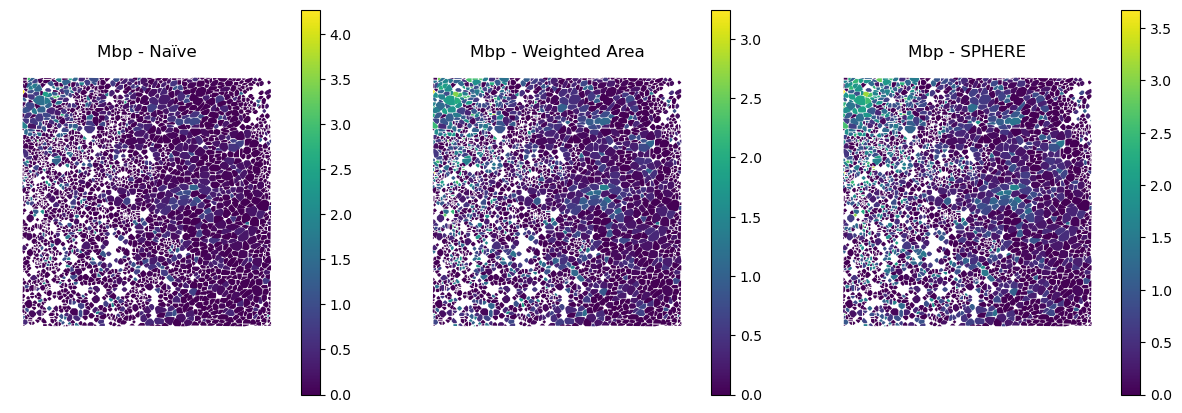

Figure 5 done on patch.


In [14]:
# 3. 提取这个 patch
adata_patch = extract_patch(adata, best_patch_id)

# 4. 在这个 patch 上跑 Figure 5
figure5_on_patch(adata_patch, mpp=0.5)